# The importance of drift compensation on packet selection

Run a simulation where the frequency offset is reasonably stable, but sufficiently high. That is, RTC with good stability, but relatively poor tolerance. Also, define a relatively low PDV variance, so that the delay PDF is well "concentrated".

In [9]:
import sys, os
sys.path.append(os.path.abspath('../'))
import ptp.runner
import ptp.ls
import ptp.metrics
import ptp.pktselection
import ptp.kalman
import ptp.frequency
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# Parameters
n_iter     = 4096               # Number of runner iterations
N_ls       = 2048               # LS window
N_movavg   = 128                # Moving average window
N_median   = 128                # Sample-median window
N_min      = 128                # Sample-minimum window
N_ewma     = 64                 # EWMA window
freq_delta = 16                 # Freq. offset estimation delta
show_pkts  = True
show_ls    = True
show_kf    = True
show_raw   = False
show_best  = True

# Run PTP simulation
runner = ptp.runner.Runner(n_iter = n_iter, freq_tolerance=300, freq_rw=0.01, gamma_scale=100)
runner.run()

# Least-squares estimator
ls = ptp.ls.Ls(N_ls, runner.data, runner.sync_period*1e9)
ls.process(impl="eff")

Runner progress:  10.01 %
Runner progress:  20.02 %
Runner progress:  30.03 %
Runner progress:  40.04 %
Runner progress:  50.05 %
Runner progress:  60.06 %
Runner progress:  70.07 %
Runner progress:  80.08 %
Runner progress:  90.09 %
Runner progress: 100.00 %


Collect raw time offset and delay measurements:

In [10]:
x_obs = [res["x_est"] for res in runner.data]
d_obs = [res["d_est"] for res in runner.data]

Define an arbitrary observation window and take the $t_2 - t_1$ and $t_4 - t_3$ differences:

In [11]:
# Window start and end indexes
i_s = 2300
i_e = i_s + N_min

t2_minus_t1_w = np.array([float(r["t2"] - r["t1"]) for r in runner.data[i_s:i_e]])
t4_minus_t3_w = np.array([float(r["t4"] - r["t3"]) for r in runner.data[i_s:i_e]])

Get the frequency offset estimate from LS and predict the drift within the observation window:

In [12]:
# Compute the drift within the observation window
ls_impl = "eff"
t_w     = np.array([float(r["t1"] - runner.data[i_s]["t1"]) for r in runner.data[i_s:i_e]])
y       = runner.data[i_e - 1]["y_ls_{}".format(ls_impl)]
drift   = y * t_w
print("y estimated: %f ppb\ttrue: %f ppb" %(y*1e9, runner.data[i_e - 1]["rtc_y"]))

y estimated: 796188057.449506 ppb	true: 1.745690 ppb


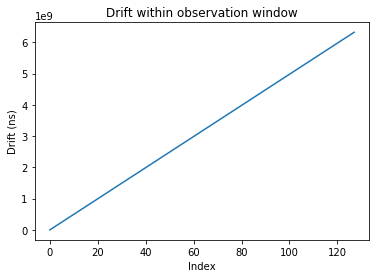

In [13]:
plt.figure()
plt.plot(drift)
plt.xlabel("Index")
plt.ylabel("Drift (ns)")
plt.title("Drift within observation window")
plt.show()

## Sample-minimum packet selection

### Without frequency compensation

Compute: 

$$  \hat{x}[k] \doteq \frac{1}{2} \left(
  \min_{kN \leq n < (k+1)N}\left\{t_2[n] - t_1[n]\right\}
  - \min_{kN \leq n < (k+1)N}\left\{t_4[n] - t_3[n]\right\}
  \right)$$

In [14]:
t2_minus_t1 = np.amin(t2_minus_t1_w)
t4_minus_t3 = np.amin(t4_minus_t3_w)

print("argmin(t2-t1): %d\targmin(t4-t3): %d" %(
np.argmin(t2_minus_t1_w), np.argmin(t4_minus_t3_w)))

x     = runner.data[i_e - 1]["x"]
x_est = (t2_minus_t1 - t4_minus_t3)/2
print("x estimated: %f ns\ttrue: %f ns" %(x_est, x))
print("Error: %f" %(x_est - x))

argmin(t2-t1): 0	argmin(t4-t3): 127
x estimated: 108819183279.650208 ns	true: 115361454431.650223 ns
Error: -6542271152.000015


Note that due to frequency offset, the minimum of one will be in the beginning of the observation window and the minimum of the other will be in the end, depending on the sign of the frequency offset.

This can be better understood by observing the $t_2 - t_1$ and $t_4 - t_3$ differences:

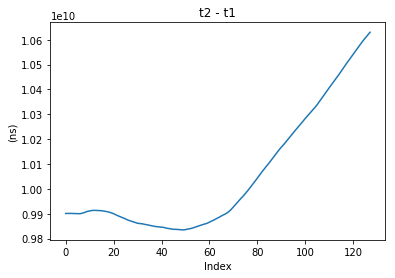

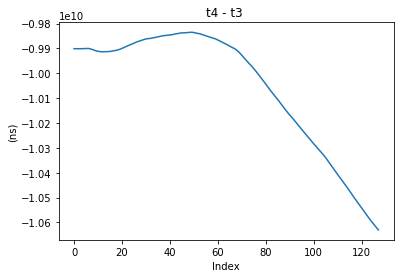

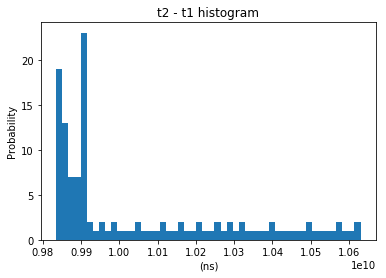

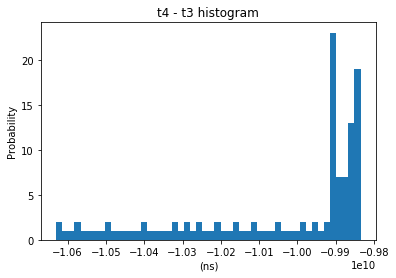

In [7]:
plt.figure()
plt.plot(t2_minus_t1_w)
plt.xlabel("Index")
plt.ylabel("(ns)")
plt.title("t2 - t1")
plt.show()

plt.figure()
plt.plot(t4_minus_t3_w)
plt.xlabel("Index")
plt.ylabel("(ns)")
plt.title("t4 - t3 ")
plt.show()

plt.figure()
plt.hist(t2_minus_t1_w, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("t2 - t1 histogram")
plt.show()

plt.figure()
plt.hist(t4_minus_t3_w, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("t4 - t3 histogram")
plt.show()

### With frequency compensation

First observe the compensated differences:

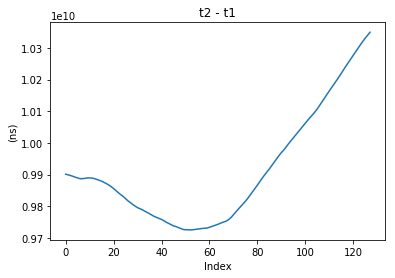

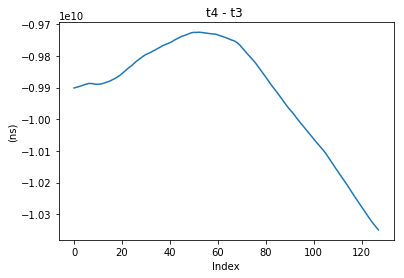

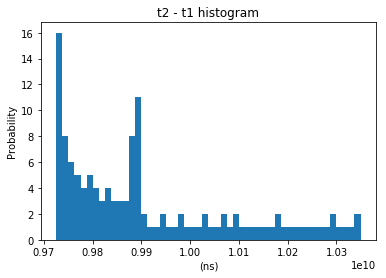

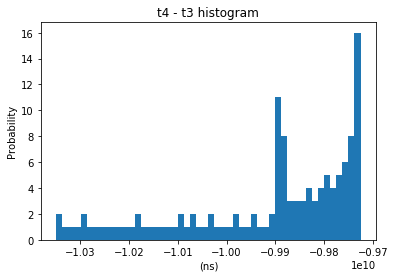

In [8]:
t2_minus_t1_w_freq_corr = t2_minus_t1_w - drift
t4_minus_t3_w_freq_corr = t4_minus_t3_w + drift

plt.figure()
plt.plot(t2_minus_t1_w_freq_corr)
plt.xlabel("Index")
plt.ylabel("(ns)")
plt.title("t2 - t1")
plt.show()

plt.figure()
plt.xlabel("Index")
plt.ylabel("(ns)")
plt.title("t4 - t3 ")
plt.plot(t4_minus_t3_w_freq_corr)
plt.show()

plt.figure()
plt.hist(t2_minus_t1_w_freq_corr, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("t2 - t1 histogram")
plt.show()

plt.figure()
plt.hist(t4_minus_t3_w_freq_corr, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("t4 - t3 histogram")
plt.show()

In [9]:
t2_minus_t1 = np.amin(t2_minus_t1_w_freq_corr)
t4_minus_t3 = np.amin(t4_minus_t3_w_freq_corr)

print("min(t2-t1): %d\tmin(t4-t3): %d" %(
np.amin(t2_minus_t1_w_freq_corr), np.amin(t4_minus_t3_w_freq_corr)))
print("argmin(t2-t1): %d\targmin(t4-t3): %d" %(
np.argmin(t2_minus_t1_w_freq_corr), np.argmin(t4_minus_t3_w_freq_corr)))

x     = runner.data[i_e - 1]["x"]
x_est = (t2_minus_t1 - t4_minus_t3)/2 + drift[-1]
print("x estimated: %f ns\ttrue: %f ns" %(x_est, x))
print("Error: %f" %(x_est - x))

min(t2-t1): 9725140566	min(t4-t3): -10349328372
argmin(t2-t1): 52	argmin(t4-t3): 127
x estimated: 10318029780.349005 ns	true: 10630123987.471601 ns
Error: -312094207.122597


## Sample-mode packet selection

### Without frequency compensation

argmode(t2-t1): 49	argmode(t4-t3): 127


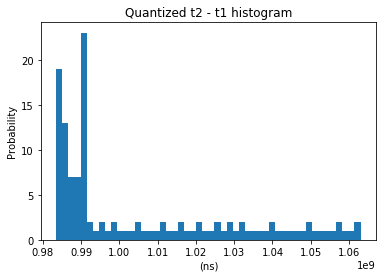

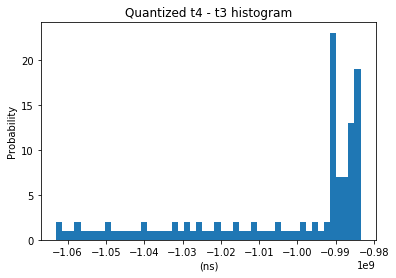

x estimated: 10232554530.000000 ns	true: 10630123987.471601 ns
Error: -397569457.471601


In [10]:
bin_width = 10

# Quantize timestamp difference vectors
t2_minus_t1_q = np.round(t2_minus_t1_w / bin_width)
t4_minus_t3_q = np.round(t4_minus_t3_w / bin_width)

# Find the mode for (t2 - t1)
(_, idx, counts) = np.unique(t2_minus_t1_q, return_index=True, return_counts=True)
mode_idx_fw      = idx[np.argmax(counts)]
t2_minus_t1      = t2_minus_t1_q[mode_idx_fw] * bin_width

# Find the mode for (t4 - t3)
(_, idx, counts) = np.unique(t4_minus_t3_q, return_index=True, return_counts=True)
mode_idx_bw      = idx[np.argmax(counts)]
t4_minus_t3      = t4_minus_t3_q[mode_idx_bw] * bin_width

print("argmode(t2-t1): %d\targmode(t4-t3): %d" %(mode_idx_fw, mode_idx_bw))

plt.figure()
plt.hist(t2_minus_t1_q, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("Quantized t2 - t1 histogram")
plt.show()

plt.figure()
plt.hist(t4_minus_t3_q, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("Quantized t4 - t3 histogram")
plt.show()

x     = runner.data[i_e - 1]["x"]
x_est = (t2_minus_t1 - t4_minus_t3)/2
print("x estimated: %f ns\ttrue: %f ns" %(x_est, x))
print("Error: %f" %(x_est - x))

### After drift compensation

mode(t2-t1): 972514057	mode(t4-t3): -1034932837
argmode(t2-t1): 52	argmode(t4-t3): 127
count mode(t2-t1): 1	count mode(t4-t3): 1


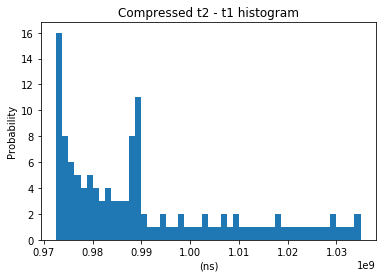

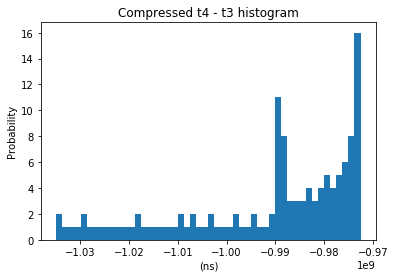

x estimated: 10318029780.672850 ns	true: 10630123987.471601 ns
Error: -312094206.798752


In [11]:
bin_width = 10

# Quantize timestamp difference vectors
t2_minus_t1_q = np.round(t2_minus_t1_w_freq_corr / bin_width)
t4_minus_t3_q = np.round(t4_minus_t3_w_freq_corr / bin_width)

# Find the mode for (t2 - t1)
(_, idx, counts_fw) = np.unique(t2_minus_t1_q, return_index=True, return_counts=True)
mode_idx_fw         = idx[np.argmax(counts_fw)]
t2_minus_t1         = t2_minus_t1_q[mode_idx_fw] * bin_width

# Find the mode for (t4 - t3)
(_, idx, counts_bw) = np.unique(t4_minus_t3_q, return_index=True, return_counts=True)
mode_idx_bw         = idx[np.argmax(counts_bw)]
t4_minus_t3         = t4_minus_t3_q[mode_idx_bw] * bin_width

print("mode(t2-t1): %d\tmode(t4-t3): %d" %(t2_minus_t1_q[mode_idx_fw], t4_minus_t3_q[mode_idx_bw]))
print("argmode(t2-t1): %d\targmode(t4-t3): %d" %(mode_idx_fw, mode_idx_bw))
print("count mode(t2-t1): %d\tcount mode(t4-t3): %d" %(np.amax(counts_fw), np.amax(counts_bw)))

plt.figure()
plt.hist(t2_minus_t1_q, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("Compressed t2 - t1 histogram")
plt.show()

plt.figure()
plt.hist(t4_minus_t3_q, bins=50)
plt.ylabel("Probability")
plt.xlabel("(ns)")
plt.title("Compressed t4 - t3 histogram")
plt.show()

x     = runner.data[i_e - 1]["x"]
x_est = (t2_minus_t1 - t4_minus_t3)/2 + drift[-1]
print("x estimated: %f ns\ttrue: %f ns" %(x_est, x))
print("Error: %f" %(x_est - x))